In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Define latent dimension for the generator input
latent_dim = 100

# Fetch historical data for the 10-year U.S. Treasury yield (interest rate proxy)
ticker = '^TNX'  # Symbol for the 10-year U.S. Treasury yield (in percentage)
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

# Use the 'Adj Close' as the interest rate (percentage)
interest_rates = data['Adj Close']

# Normalize the interest rates for GAN
interest_rates_normalized = (interest_rates - interest_rates.mean()) / interest_rates.std()
interest_rates_normalized = interest_rates_normalized.values.reshape(-1, 1)

# Build the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))  # Output is one interest rate value
    return model

# Build the Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output probability of real or fake
    return model

# Build the GAN (combining generator and discriminator)
def build_gan(generator, discriminator):
    # Freeze discriminator when training the generator
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the models
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = build_generator(latent_dim)

# The GAN model combines the generator and the discriminator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Hyperparameters
batch_size = 32
epochs = 10000
half_batch = batch_size // 2


[*********************100%***********************]  1 of 1 completed
/home/j/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Error during discriminator training: 'NoneType' object has no attribute 'update_state'


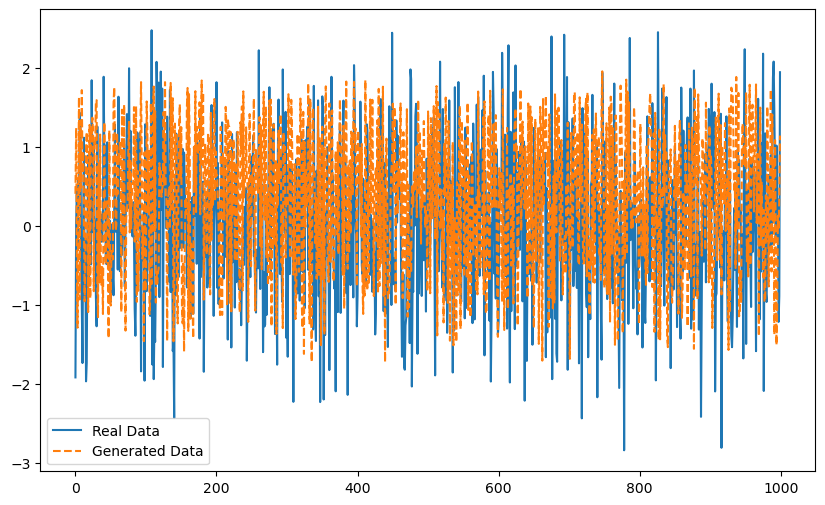

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Set the latent dimension for the generator input
latent_dim = 100

# Build the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))  # Output is a single value (e.g., a number)
    return model

# Build the Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output probability of real or fake
    return model

# Build the GAN (combining the generator and the discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator weights during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize the models
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = build_generator(latent_dim)

# Create the GAN by combining the generator and discriminator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Hyperparameters
batch_size = 32
epochs = 10
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):
    # Generate random data for real (normal distribution) and fake (from generator)
    real_data = np.random.normal(0, 1, (half_batch, 1))  # Random "real" data (for simplicity)
    
    # Check if real_data contains NaN or Inf values
    if np.any(np.isnan(real_data)) or np.any(np.isinf(real_data)):
        print("Warning: real_data contains NaN or Inf")
        continue

    # Noise for generator (input to generator)
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Random noise for the generator
    fake_data = generator.predict(noise)  # Generate fake data from noise

    # Ensure fake data is also valid
    if np.any(np.isnan(fake_data)) or np.any(np.isinf(fake_data)):
        print("Warning: fake_data contains NaN or Inf")
        continue

    # Labels for real and fake data
    real_labels = np.ones((half_batch, 1))  # Real data labeled as 1
    fake_labels = np.zeros((half_batch, 1))  # Fake data labeled as 0

    # Train the discriminator with real and fake data
    try:
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    except Exception as e:
        print(f"Error during discriminator training: {e}")
        continue

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Combine losses

    # Train the generator via the GAN (the goal is to fool the discriminator into thinking fake data is real)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Generate random noise
    valid_labels = np.ones((batch_size, 1))  # We want to fool the discriminator into thinking it's real

    try:
        g_loss = gan.train_on_batch(noise, valid_labels)
    except Exception as e:
        print(f"Error during generator training: {e}")
        continue

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Generate synthetic data after training
noise = np.random.normal(0, 1, (1000, latent_dim))  # Generate synthetic samples
synthetic_data = generator.predict(noise)

# Rescale back to the range of real data (adjust as needed based on your data range)
synthetic_data_rescaled = synthetic_data * 2  # Adjust as needed based on your data range

# Plot real vs synthetic data
plt.figure(figsize=(10, 6))
plt.plot(np.random.normal(0, 1, (1000, 1)), label='Real Data')
plt.plot(synthetic_data_rescaled, label='Generated Data', linestyle='dashed')
plt.legend()
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Reduce latent dimension to reduce computation
latent_dim = 10  # Smaller latent dimension

# Build Generator model (simplified with fewer neurons and layers)
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_dim=latent_dim))  # Smaller layers
    model.add(layers.Dense(16, activation='relu'))  # Reduced complexity
    model.add(layers.Dense(1, activation='tanh'))  # Output a single value
    return model

# Build Discriminator model (simplified)
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(1,)))  # Fewer neurons
    model.add(layers.Dense(32, activation='relu'))  # Smaller number of layers
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid output for binary classification
    return model

# Build GAN (combine generator and discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize and compile models
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002), metrics=['accuracy'])

generator = build_generator(latent_dim)

# Combine the generator and discriminator into a GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002))

# Hyperparameters
batch_size = 8  # Smaller batch size for less memory consumption
epochs = 1000  # Reduced number of epochs
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):
    # Generate random real data and fake data
    real_data = np.random.normal(0, 1, (half_batch, 1))  # Random "real" data
    
    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Random noise for generator input
    fake_data = generator.predict(noise)  # Generate fake data from noise
    
    # Labels for real and fake data
    real_labels = np.ones((half_batch, 1))  # Real data labeled as 1
    fake_labels = np.zeros((half_batch, 1))  # Fake data labeled as 0

    # Train the discriminator with real and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average discriminator loss

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Random noise for generator
    valid_labels = np.ones((batch_size, 1))  # Generator wants to create "real" data

    g_loss = gan.train_on_batch(noise, valid_labels)  # Train generator via GAN

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Generate synthetic data after training
noise = np.random.normal(0, 1, (1000, latent_dim))  # Generate random noise
synthetic_data = generator.predict(noise)

# Rescale synthetic data to a similar range as the real data
synthetic_data_rescaled = synthetic_data * 2  # Rescale if necessary (adjust based on real data range)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.random.normal(0, 1, (1000, 1)), label='Real Data')  # Random real data for visualization
plt.plot(synthetic_data_rescaled, label='Generated Data', linestyle='dashed')
plt.legend()
plt.show()


ValueError: Argument(s) not recognized: {'lr': 0.0002}

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Reduce latent dimension to reduce computation
latent_dim = 10  # Smaller latent dimension

# Build Generator model (simplified with fewer neurons and layers)
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_dim=latent_dim))  # Smaller layers
    model.add(layers.Dense(16, activation='relu'))  # Reduced complexity
    model.add(layers.Dense(1, activation='tanh'))  # Output a single value
    return model

# Build Discriminator model (simplified)
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(1,)))  # Fewer neurons
    model.add(layers.Dense(32, activation='relu'))  # Smaller number of layers
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid output for binary classification
    return model

# Build GAN (combine generator and discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize and compile models
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

generator = build_generator(latent_dim)

# Combine the generator and discriminator into a GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))

# Hyperparameters
batch_size = 8  # Smaller batch size for less memory consumption
epochs = 1000  # Reduced number of epochs
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):
    # Generate random real data and fake data
    real_data = np.random.normal(0, 1, (half_batch, 1))  # Random "real" data
    
    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Random noise for generator input
    fake_data = generator.predict(noise)  # Generate fake data from noise
    
    # Labels for real and fake data
    real_labels = np.ones((half_batch, 1))  # Real data labeled as 1
    fake_labels = np.zeros((half_batch, 1))  # Fake data labeled as 0

    # Train the discriminator with real and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average discriminator loss

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Random noise for generator
    valid_labels = np.ones((batch_size, 1))  # Generator wants to create "real" data

    g_loss = gan.train_on_batch(noise, valid_labels)  # Train generator via GAN

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Generate synthetic data after training
noise = np.random.normal(0, 1, (1000, latent_dim))  # Generate random noise
synthetic_data = generator.predict(noise)

# Rescale synthetic data to a similar range as the real data
synthetic_data_rescaled = synthetic_data * 2  # Rescale if necessary (adjust based on real data range)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.random.normal(0, 1, (1000, 1)), label='Real Data')  # Random real data for visualization
plt.plot(synthetic_data_rescaled, label='Generated Data', linestyle='dashed')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Latent dimension for generator input
latent_dim = 10  # Reduce to make the model computationally cheaper

# Build the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))  # Output a single value
    return model

# Build the Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output probability
    return model

# Build the GAN model (combines the generator and discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator when training the generator
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize the models
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

generator = build_generator(latent_dim)

# Compile the GAN model after the discriminator is frozen
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))

# Hyperparameters
batch_size = 8  # Small batch size for less memory usage
epochs = 1000  # Number of epochs
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):
    # Generate random real data and fake data
    real_data = np.random.normal(0, 1, (half_batch, 1))  # Fake "real" data for training the discriminator
    
    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Random noise for generator input
    fake_data = generator.predict(noise)  # Generate fake data from noise
    
    # Labels for real and fake data
    real_labels = np.ones((half_batch, 1))  # Real data labeled as 1
    fake_labels = np.zeros((half_batch, 1))  # Fake data labeled as 0

    # Train the discriminator with real and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average discriminator loss

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Random noise for generator input
    valid_labels = np.ones((batch_size, 1))  # Generator wants to create "real" data

    # Train the generator via GAN
    g_loss = gan.train_on_batch(noise, valid_labels)  # Train the GAN model (generator only)

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Generate synthetic data after training
noise = np.random.normal(0, 1, (1000, latent_dim))  # Generate random noise
synthetic_data = generator.predict(noise)

# Rescale synthetic data (optional, based on real data range)
synthetic_data_rescaled = synthetic_data * 2  # Adjust scaling factor if necessary

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(np.random.normal(0, 1, (1000, 1)), label='Real Data')  # Fake "real" data for visualization
plt.plot(synthetic_data_rescaled, label='Generated Data', linestyle='dashed')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [13]:
!pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/j/anaconda3/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 


In [15]:
# Verify discriminator compilation
try:
    discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
    print("Discriminator compiled successfully.")
except Exception as e:
    print(f"Discriminator compile error: {e}")

# Verify GAN compilation
try:
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    print("GAN compiled successfully.")
except Exception as e:
    print(f"GAN compile error: {e}")


Discriminator compiled successfully.
GAN compiled successfully.


In [17]:
print(f"Real data shape: {real_data.shape}")
print(f"Fake data shape: {fake_data.shape}")


Real data shape: (4, 1)
Fake data shape: (4, 1)


In [19]:
# Training loop
for epoch in range(epochs):
    # Generate random real data and fake data
    real_data = np.random.normal(0, 1, (half_batch, 1))  # Fake "real" data for training the discriminator
    
    # Generate fake data using the generator
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Random noise for generator input
    fake_data = generator.predict(noise)  # Generate fake data from noise
    
    # Labels for real and fake data
    real_labels = np.ones((half_batch, 1))  # Real data labeled as 1
    fake_labels = np.zeros((half_batch, 1))  # Fake data labeled as 0

    # Train the discriminator with real and fake data
    print(f"Epoch {epoch}: Training Discriminator...")
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average discriminator loss

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Random noise for generator input
    valid_labels = np.ones((batch_size, 1))  # Generator wants to create "real" data

    print(f"Epoch {epoch}: Training Generator...")
    g_loss = gan.train_on_batch(noise, valid_labels)  # Train the GAN model (generator only)

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 0: Training Discriminator...


AttributeError: 'NoneType' object has no attribute 'update_state'

In [21]:
real_data = np.random.normal(0, 1, (half_batch, 1))  # Real data
fake_data = generator.predict(np.random.normal(0, 1, (half_batch, latent_dim)))  # Fake data
real_labels = np.ones((half_batch, 1))  # Labels for real data
fake_labels = np.zeros((half_batch, 1))  # Labels for fake data

# Training the discriminator
d_loss_real = discriminator.train_on_batch(real_data, real_labels)
d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [23]:
from tensorflow.keras import layers, models
import numpy as np

# Define the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))  # Output size should be 1 for simplicity
    return model

# Define the Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output is scalar
    return model

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [25]:
# Hyperparameters
batch_size = 32
epochs = 10000
half_batch = batch_size // 2

# Dummy data to simulate the interest rates (one feature for simplicity)
real_data = np.random.normal(0, 1, (half_batch, 1))  # Simulated real data (normally distributed)
real_labels = np.ones((half_batch, 1))  # Labels for real data (1s)

# Training loop
for epoch in range(epochs):
    # 1. Train the Discriminator (real vs fake)
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Generate random noise
    fake_data = generator.predict(noise)  # Generate fake data from noise
    fake_labels = np.zeros((half_batch, 1))  # Labels for fake data (0s)
    
    # Train discriminator with real data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    
    # Train discriminator with fake data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    
    # Calculate the total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 2. Train the Generator via the GAN model (trying to fool the discriminator)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Generate noise for generator
    valid_labels = np.ones((batch_size, 1))  # Labels for fake data (generator tries to fool the discriminator)
    
    g_loss = gan.train_on_batch(noise, valid_labels)  # Train the generator
    
    # Print progress
    if epoch % 100 == 0:
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | G loss: {g_loss}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define latent dimension for generator input
latent_dim = 100

# Build the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))  # Output size should be 1 for simplicity
    return model

# Build the Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output is scalar
    return model

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator model
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

# Compile the GAN model
generator = build_generator(latent_dim)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Hyperparameters
batch_size = 32
epochs = 10000
half_batch = batch_size // 2

# Dummy data to simulate the interest rates (one feature for simplicity)
real_data = np.random.normal(0, 1, (half_batch, 1))  # Simulated real data (normally distributed)
real_labels = np.ones((half_batch, 1))  # Labels for real data (1s)

# Training loop
for epoch in range(epochs):
    # 1. Train the Discriminator (real vs fake)
    noise = np.random.normal(0, 1, (half_batch, latent_dim))  # Generate random noise
    fake_data = generator.predict(noise)  # Generate fake data from noise
    fake_labels = np.zeros((half_batch, 1))  # Labels for fake data (0s)
    
    # Train discriminator with real data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    
    # Train discriminator with fake data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    
    # Calculate the total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 2. Train the Generator via the GAN model (trying to fool the discriminator)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Generate noise for generator
    valid_labels = np.ones((batch_size, 1))  # Labels for fake data (generator tries to fool the discriminator)
    
    g_loss = gan.train_on_batch(noise, valid_labels)  # Train the generator
    
    # Print progress
    if epoch % 100 == 0:
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | G loss: {g_loss}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'